<a href="https://colab.research.google.com/github/opherdonchin/Grades-for-projects-anonymized/blob/main/Regression_analysis%20anonymized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for separating project grades from influence of grader

## Short description

Lots of projects. Lots of graders. Each grader, lots of sub-grades. Put them all together in a model

I built this using the outline in this page: [Bayesian Linear Regression Using PyMC3](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

## Data loading and preprocessing

### Imports

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install pymc &> /dev/null
  !pip install xlsxwriter

  from pathlib import Path
  %cd /content
  if not Path("Grades-for-projects-anonymized").is_dir():
    !git clone https://github.com/opherdonchin/Grades-for-projects-anonymized
  %cd /content/Grades-for-projects-anonymized
  %env MKL_THREADING_LAYER=GNU

In [2]:
# Imports
# Python
import platform
import os.path
import pickle
import chardet

# Maths
import numpy as np
import pandas as pd
import scipy.stats as stats

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Bayes
import xarray as xr
import aesara
import aesara.tensor as tt
import pymc as pm
import arviz as az

az.style.use("arviz-darkgrid")

In [3]:
print('Running on the PyMC3 v{}'.format(pm.__version__))


Running on the PyMC3 v4.0.0b6


### Load data

In [4]:
url_raw_data = 'data/grades talks makeup 2022.csv'

with open(url_raw_data, 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large
    
raw_data = pd.read_csv(url_raw_data, encoding = enc['encoding'], sep=",", on_bad_lines='skip')



In [5]:
raw_data.head()

,project,judge,grade
0,313610412,Judge 19,75
1,313610412,Judge 18,94
2,313610412,Judge 20,92
3,313610412,Judge 1,85
4,205666373,Judge 19,96


### Preprocess data

In [30]:
data = raw_data.copy()
data['s_idx'], project_cats = pd.factorize(data['project'], sort=True)
data['j_idx'], judge_cats = pd.factorize(data['judge'], sort=True)

print(data.head())
data['grade'].describe()


     project     judge  grade  s_idx  j_idx
0  313610412  Judge 19     75      1      2
1  313610412  Judge 18     94      1      1
2  313610412  Judge 20     92      1      3
3  313610412   Judge 1     85      1      0
4  205666373  Judge 19     96      0      2


count     8.000000
mean     89.750000
std       6.881653
min      75.000000
25%      88.000000
50%      92.500000
75%      94.000000
max      96.000000
Name: grade, dtype: float64

### Get priors from previous run

This code depends on the fit made during the initial grading of all the talks. If the sample file doesn't already exist, you will need to generate
it by running `Regression_analysis_talks_2022.ipynb`

In [7]:
trace_path = 'samples/samples talks 2022.nc'
print(f'Loading samples from {trace_path}')
idata_prior = az.from_netcdf(trace_path)


Loading samples from samples/samples talks 2022.nc


I calculate the prior constants for all the global parameters by taking appropriate means and standard deviations of the posterior samples.

In [8]:
post = idata_prior.posterior
mu_mu0,sd_mu0 = stats.norm.fit(post['mu_0'].to_series())
sd_mus = post['mu_s'].std(dim='students').mean().item()
sd_muj = post['mu_j'].std(dim='judges').mean().item()
g_sigma_a,loc,g_sigma_scale = stats.gamma.fit(post['g_sigma'].to_series(), floc=0)
g_sigma_mu = g_sigma_a*g_sigma_scale
g_sigma_sd = g_sigma_a*g_sigma_scale**2

print(f"""
{mu_mu0=}
{sd_mu0=}
{sd_mus=}
{sd_muj=}
{g_sigma_mu=}
{g_sigma_sd=}
""")



mu_mu0=88.16974273719758
sd_mu0=3.2397064169086898
sd_mus=4.321250609721763
sd_muj=4.296089533025109
g_sigma_mu=5.927288363567768
g_sigma_sd=14.213717076057709



In [9]:
judge1_coord = post['mu_j'].coords['judges']=='שופט 1'
judge1_mu_j_mu, judge1_mu_j_sigma = stats.norm.fit(post['mu_j'][:,:,judge1_coord])
judge1_g_sigma_a, loc, judge1_g_sigma_scale = stats.gamma.fit(post['g_sigma'][:,:,judge1_coord].to_series(), floc=0)
judge1_g_sigma_mu = judge1_g_sigma_a*judge1_g_sigma_scale
judge1_g_sigma_sd = judge1_g_sigma_a*judge1_g_sigma_scale**2

print(f"""
{judge1_mu_j_mu=}
{judge1_mu_j_sigma=}
{judge1_g_sigma_mu=}
{judge1_g_sigma_sd=}
""")



judge1_mu_j_mu=-1.7822762953202194
judge1_mu_j_sigma=3.5867008074024316
judge1_g_sigma_mu=5.612334584231527
judge1_g_sigma_sd=7.806828521054478



## Model definition and fitting

### Define model

In [51]:
def regression_model(s_idx, j_idx, grade, s_cats, j_cats):

  coords = {"students": s_cats, "judges": j_cats, "measures":np.arange(len(grade))}
  with pm.Model(coords=coords) as model:
    # Data
    s = pm.ConstantData("s", s_idx, dims=["measures"])
    j = pm.ConstantData("j", j_idx, dims=["measures"])

    # Priors
    mu_0 = pm.Normal('mu_0', mu=mu_mu0, sigma=sd_mu0)
    # mu_0 = pm.ConstantData('mu_0', mu_mu0)
    mu_s = pm.Normal('mu_s', mu=0, sigma=sd_mus, dims=["students"])
    
    
    is_j1 = pm.ConstantData('is_j1', np.where(coords["judges"]=='Judge 1',1,0))
    mu_j_all = pm.Normal('mu_j_all', mu=0, sigma=sd_muj, dims=["judges"])
    mu_j1 = pm.Normal('mu_j1', mu=judge1_mu_j_mu,sigma=judge1_mu_j_sigma)
    mu_j = pm.Deterministic('mu_j', (1-is_j1)*mu_j_all + is_j1*mu_j1)

    # Regression variables
    g_mu = pm.Deterministic('g_mu', mu_0 + mu_s[s] + mu_j[j], dims=["measures"])

    g_sigma = pm.Gamma('g_sigma', mu=g_sigma_mu, sigma=g_sigma_sd)
    # g_sigma1 = pm.Gamma('g_sigma1', mu=judge1_g_sigma_mu, sigma=judge1_g_sigma_sd)
    # g_sigma = pm.Deterministic('g_sigma', (1-is_j1)*g_sigma_all + is_j1*g_sigma1)
    # g_nu = pm.Exponential("g_nu", lam=lambda_g_nu)

    # Likelihood 
    pm.Normal('g_obs', mu=g_mu, sigma=g_sigma, observed=grade, dims=["measures"])
  return model


### Show model

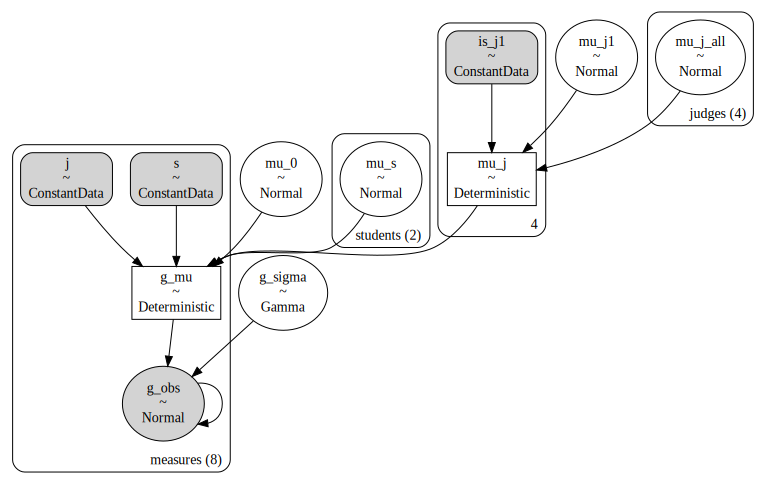

In [52]:
model = regression_model(data.s_idx, data.j_idx, data.grade, project_cats, judge_cats)
pm.model_to_graphviz(model)

### Sample model
Load samples from file if they are already there

In [54]:
trace_path = 'samples/grades talks makeup 2022.nc'
model_description = f'your model'
if not os.path.isfile(trace_path):
  print(f'Resampling {model_description}')
  model = regression_model(data.s_idx, data.j_idx, data.grade, project_cats, judge_cats)
  with model:
    idata = pm.sample(draws=5000, tune=4000, cores=5, target_accept=0.999, return_inferencedata=True)  
  print(f'Saving samples to {trace_path}')
  az.to_netcdf(idata, trace_path)
else:
  print(f'Loading samples for {model_description} from {trace_path}')
  idata = az.from_netcdf(trace_path)



Resampling your model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\miniconda3\envs\ProjectGrades\lib\site-packages\pymc\aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [mu_0, mu_s, mu_j_all, mu_j1, g_sigma]


Sampling 5 chains for 4_000 tune and 5_000 draw iterations (20_000 + 25_000 draws total) took 186 seconds.


Saving samples to samples/grades talks makeup 2022.nc


## Diagnostics

### Show traces

array([[<AxesSubplot:title={'center':'mu_0'}>,
        <AxesSubplot:title={'center':'mu_0'}>],
       [<AxesSubplot:title={'center':'mu_s'}>,
        <AxesSubplot:title={'center':'mu_s'}>],
       [<AxesSubplot:title={'center':'mu_j_all'}>,
        <AxesSubplot:title={'center':'mu_j_all'}>],
       [<AxesSubplot:title={'center':'mu_j1'}>,
        <AxesSubplot:title={'center':'mu_j1'}>],
       [<AxesSubplot:title={'center':'g_sigma'}>,
        <AxesSubplot:title={'center':'g_sigma'}>],
       [<AxesSubplot:title={'center':'mu_j'}>,
        <AxesSubplot:title={'center':'mu_j'}>],
       [<AxesSubplot:title={'center':'g_mu'}>,
        <AxesSubplot:title={'center':'g_mu'}>]], dtype=object)

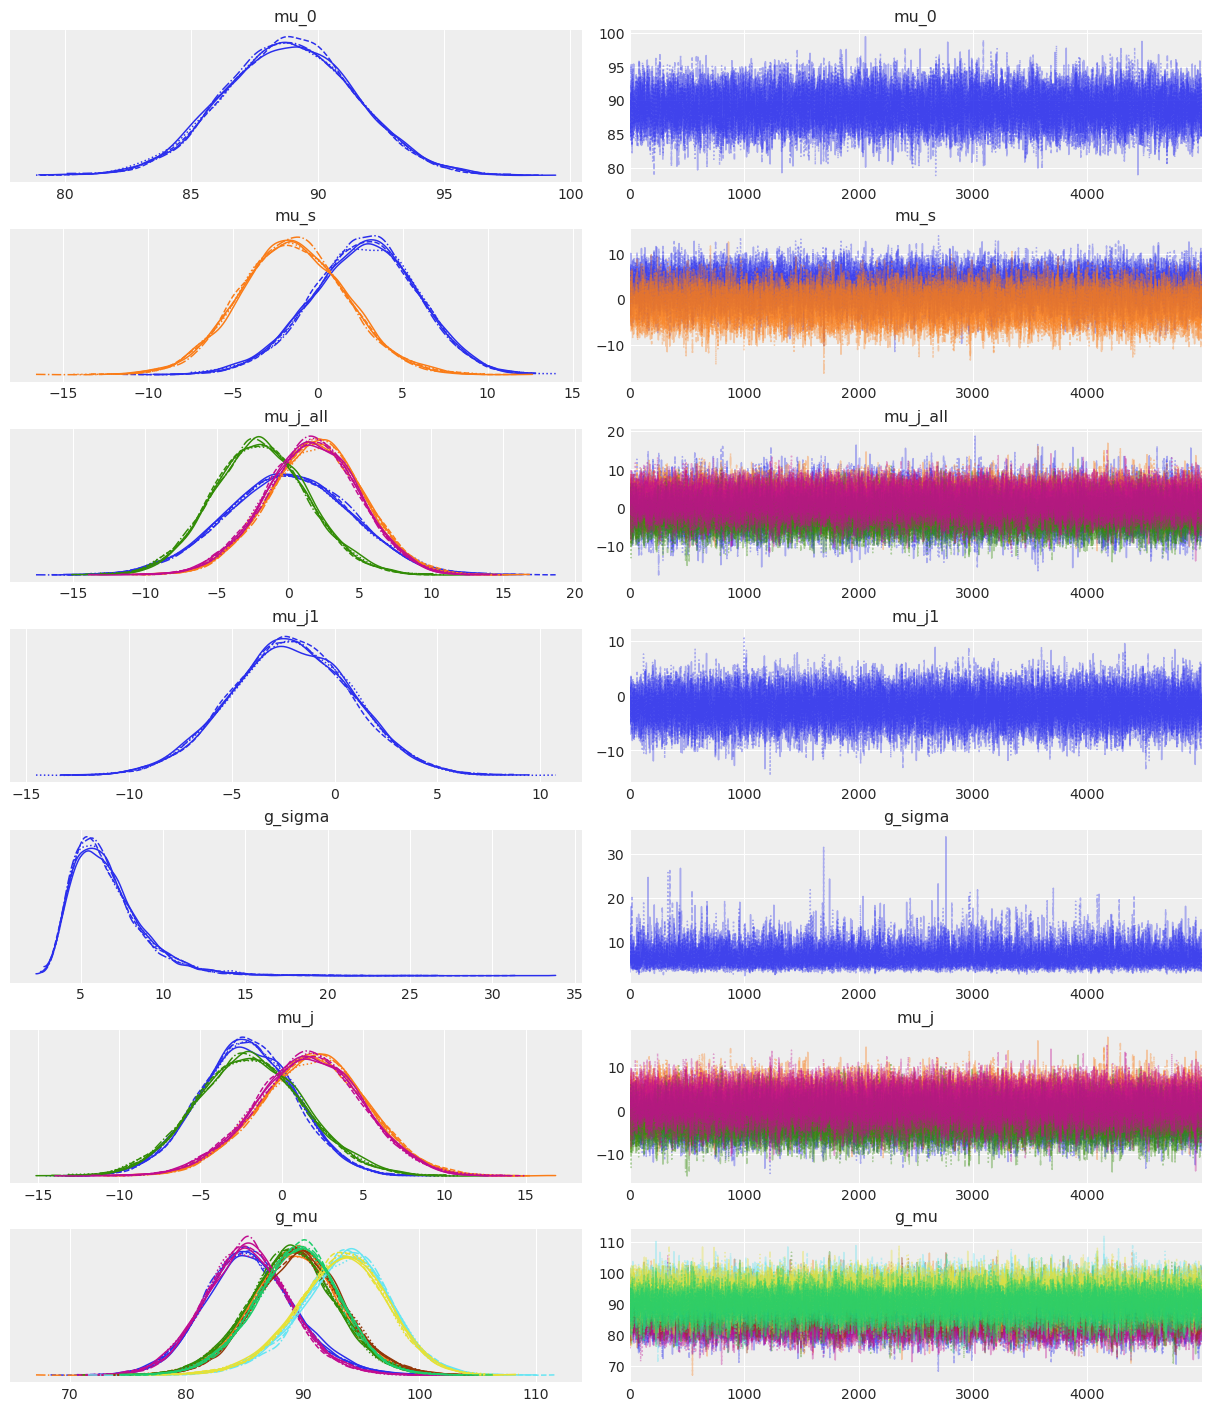

In [55]:
az.plot_trace(idata)

### Plot pairs

In [57]:
post = idata.posterior
keep_judges = [0, 1]
keep_students = [0, 1]

judge_coords = post.coords['judges']
student_coords = post.coords['students']

judge_mu_dict = {f'mu_{judge_coords[j].item()}': post['mu_j'][:,:,j] for j in keep_judges}
judge_s_dict = {f'g_sigma': post['g_sigma']}
student_dict = {f'mu_{student_coords[s].item()}': post['mu_s'][:,:,s] for s in keep_students}

plot_data = az.from_dict(
    posterior = {'mu_0':post['mu_0'], 'g_sigma':post['g_sigma'], **judge_mu_dict, **student_dict},
    sample_stats = {'diverging': idata.sample_stats.diverging}
)

c:\miniconda3\envs\ProjectGrades\lib\site-packages\arviz\plots\pairplot.py:192: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  warnings.warn(


array([[<AxesSubplot:ylabel='g_sigma'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='mu_Judge 1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='mu_Judge 18'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='mu_205666373'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='mu_0', ylabel='mu_313610412'>,
        <AxesSubplot:xlabel='g_sigma'>,
        <AxesSubplot:xlabel='mu_Judge 1'>,
        <AxesSubplot:xlabel='mu_Judge 18'>,
        <AxesSubplot:xlabel='mu_205666373'>]], dtype=object)

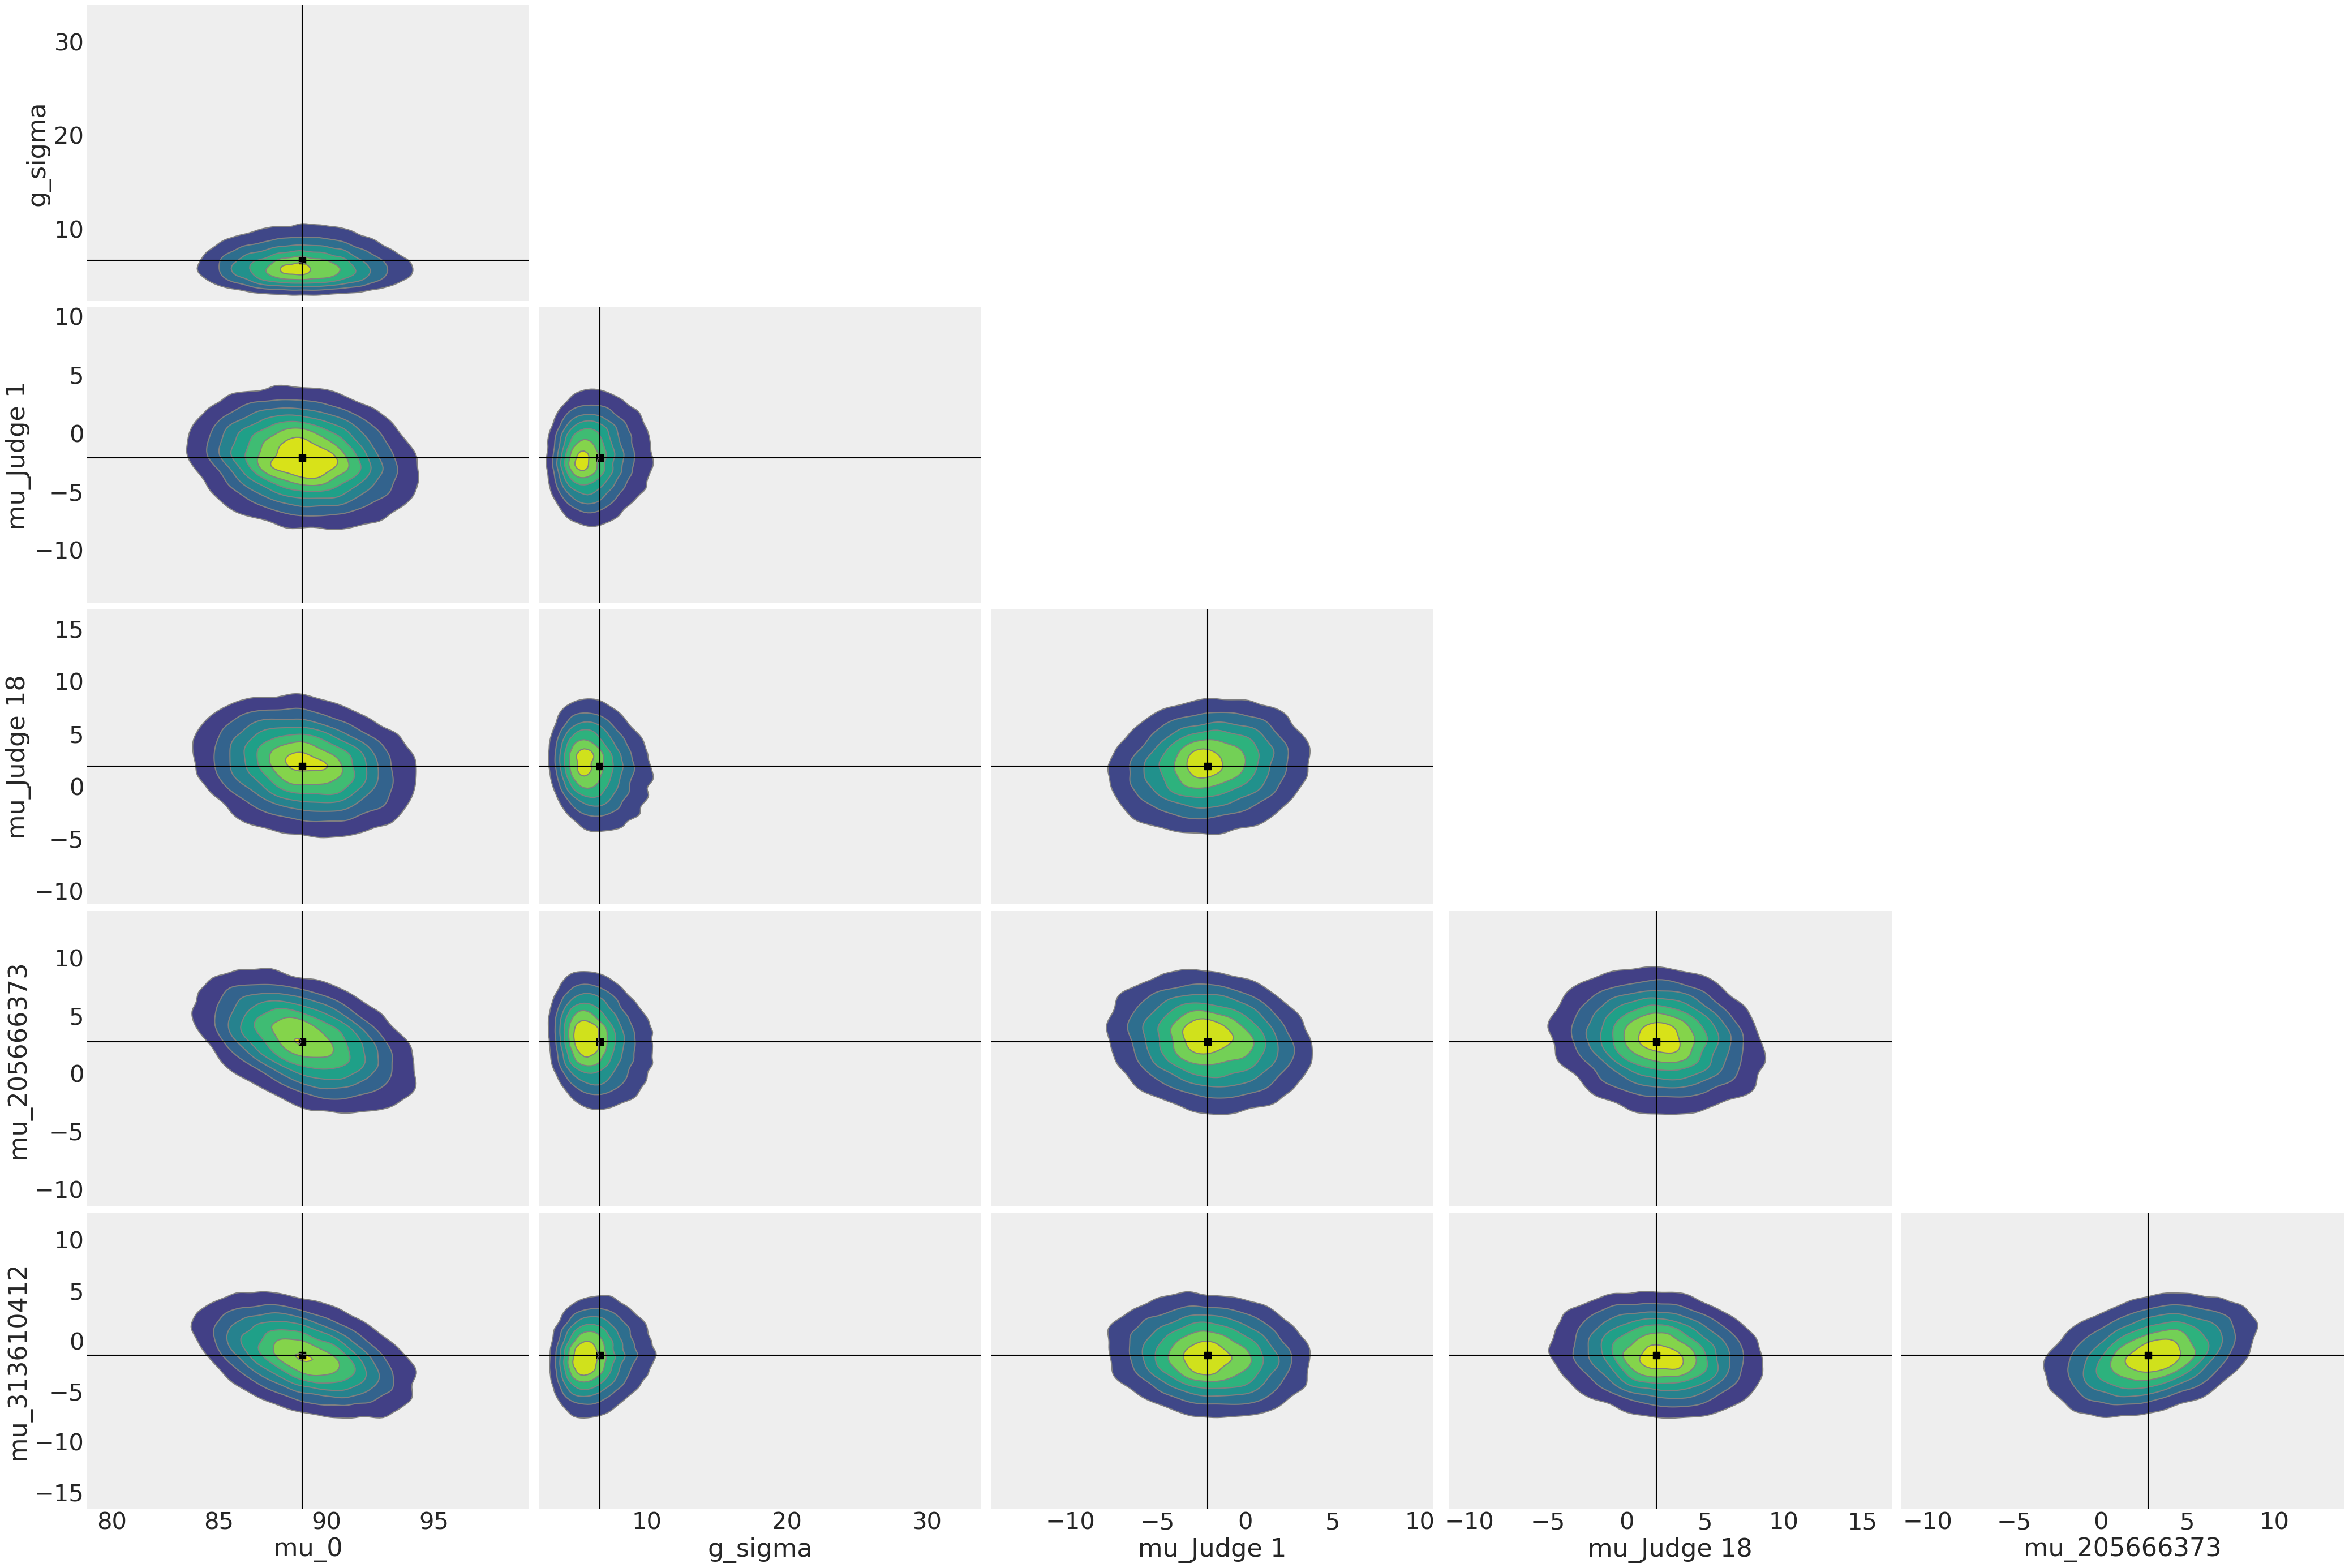

In [58]:
az.plot_pair(plot_data, kind='kde', contour=True, divergences=True, point_estimate='mean', textsize=30)

## Show results

### Plot judge means and estimates

Text(0.5, 1.0, 'Data mean and corrected value for each grader')

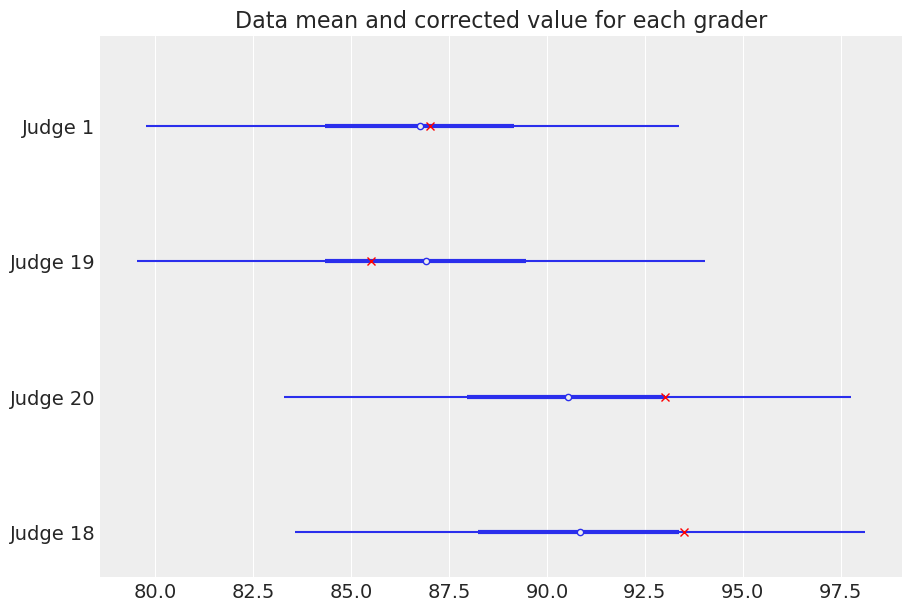

In [60]:
post = idata.posterior
mu_j = post['mu_j']
mu_0 = post['mu_0']

mu_j_mean = mu_j.mean(dim=['chain','draw'])
sort_order = mu_j_mean.argsort()

judge_coords = post.coords['judges']
reversed_names = [c.item() for c in judge_coords]

mu_j_dict = {f'{reversed_names[j.item()]}': mu_j[:,:,j]+mu_0 for j in sort_order}

plot_data = az.from_dict(
    posterior = mu_j_dict,
    sample_stats = {'diverging': idata.sample_stats.diverging}
)
ax = az.plot_forest(plot_data, kind='forestplot', combined=True, figsize=[9, 6])

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.j
xbar_j = [g_data[j_data==j].mean() for j in sort_order.to_numpy()]

y_vals = [li.get_data()[1].item() for li in ax[0].get_lines()]
y_vals = y_vals[::-1]


plt.plot(xbar_j, y_vals, linestyle='None', marker='x', color='r')
ax[0].set_title('Data mean and corrected value for each grader')


### Plot projects means and estimates
There are two ways to do this. 

1. Add the estimated mean to the estimated project to get a value that leaves out the judges
2. Subtract the judge mean from the scores to get a corrected score per project

The difference comes fom whether we keep the unexplained variance or discard it. Keeping it will bring up the score of teh worst project and bring
down the score of the best project. 

The current plot shows both.

In [66]:
mu_j_mean.to_numpy()[j_data.to_numpy()]

array([-1.95259392,  1.90483719,  1.63398783, -2.12263652, -1.95259392,
        1.90483719,  1.63398783, -2.12263652])

Text(0.5, 1.0, 'Data mean and corrected mean of each project')

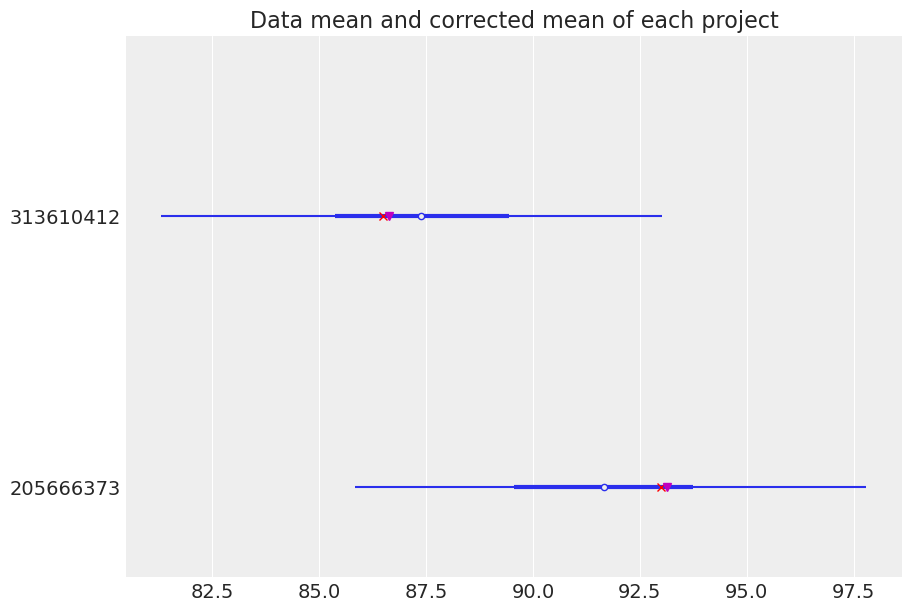

In [67]:
post = idata.posterior
mu_s = post['mu_s']
mu_0 = post['mu_0']

student_coords = post.coords['students']
reversed_names = [c.item() for c in student_coords]

mu_s_mean = mu_s.mean(dim=['chain','draw'])
sort_order = mu_s_mean.argsort()
mu_s_dict = {f'{reversed_names[s.item()]}': mu_s[:,:,s]+mu_0 for s in sort_order}

plot_data = az.from_dict(
    posterior = mu_s_dict,
    sample_stats = {'diverging': idata.sample_stats.diverging}
)
ax = az.plot_forest(plot_data, kind='forestplot', combined=True, figsize=[9, 6])
ax[0].set_title('Offsets of the different projects')

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.j
s_data = idata.constant_data.s

xbar_s = [g_data[s_data==s].mean() for s in sort_order.to_numpy()]

g_data_corrected = g_data-mu_j_mean.to_numpy()[j_data.to_numpy()]
xbar_s_corrected = [g_data_corrected[s_data==s].mean() for s in sort_order.to_numpy()]

y_vals = [li.get_data()[1].item() for li in ax[0].get_lines()]
y_vals = y_vals[::-1]


plt.plot(xbar_s, y_vals, linestyle='None', marker='x', color='r')
plt.plot(xbar_s_corrected, y_vals, linestyle='None', marker='v', color='m')
ax[0].set_title('Data mean and corrected mean of each project')


### Make a table of the different judges

For each judge, the table will show the projects that they judged along with their grade for that project, then the straight average of all 
the judges, then our estimated grade, and finally their grade for this project corrected by our estimated correction for them.

In [75]:
idata.constant_data

<xarray.Dataset>
Dimensions:      (measures: 8, is_j1_dim_0: 4)
Coordinates:
  * measures     (measures) int32 0 1 2 3 4 5 6 7
  * is_j1_dim_0  (is_j1_dim_0) int32 0 1 2 3
Data variables:
    s            (measures) int32 1 1 1 1 0 0 0 0
    j            (measures) int32 2 1 3 0 2 1 3 0
    is_j1        (is_j1_dim_0) int32 1 0 0 0
Attributes:
    created_at:                 2022-07-09T18:42:06.914105
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.0b6

In [76]:
post = idata.posterior
mu_j = post['mu_j']
sigma_g = post['g_sigma']
mu_p = post['mu_s']
mu_0 = post['mu_0']

mu_j_mean = mu_j.mean(dim=['chain','draw'])
sigma_g_mean = sigma_g.mean(dim=['chain', 'draw'])
mu_p_mean_score = (mu_0 + mu_p).mean(dim=['chain', 'draw'])
sort_order_j = mu_j_mean.argsort()
sort_order_p = mu_s_mean.argsort()

judge_coords = post.coords['judges']
project_coords = post.coords['students']

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.j
p_data = idata.constant_data.s

# Data means for judges and projects
xbar_j = [g_data[j_data==j].mean() for j in sort_order_j]
xbar_p = [g_data[p_data==p].mean() for p in np.arange(len(project_coords))]



max_proj = 0
df_rows = list()
titles = ['Judge', 'Correction']
for j_i in sort_order_j:
    j = judge_coords[j_i]
    j_name = judge_coords[j_i].item()
    j_mu = mu_j_mean[j_i].item()
    row = [j_name] # Judge name
    row.append(j_mu)
    
    for i,p in enumerate(p_data[j_data==j_i]):
        p_i = p.item()
        p_name = project_coords[p_i].item()                      # Project name
        p_bar = xbar_p[p_i].item()                               # Project mean score
        p_j = g_data[np.logical_and(p_data == p_i, j_data == j_i)][0].item()    # Judge score
        p_mu = mu_p_mean_score[p_i].item()                       # Estimates project score
        p_j_corrected = p_j - mu_j_mean[j_i].item()          # Mean score corrected for grader

        row.append(p_name) 
        row.append(p_bar)
        row.append(p_j)
        row.append(p_mu)
        row.append(p_j_corrected)
        if len(row) > len(titles):
            titles.append(f'Project {i}')
            titles.append(f'Grade {i}')
            titles.append(f'Judge grade {i}')
            titles.append(f'Estimated {i}')
            titles.append(f'Corrected {i}')

    df_rows.append(row)

grader_table = pd.DataFrame(df_rows, columns=titles)


In [77]:
grader_table.head()

,Judge,Correction,Project 0,Grade 0,Judge grade 0,Estimated 0,Corrected 0,Project 1,Grade 1,Judge grade 1,Estimated 1,Corrected 1
0,Judge 1,-2.122637,313610412,86.5,85.0,87.411485,87.122637,205666373,93.0,89.0,91.612728,91.122637
1,Judge 19,-1.952594,313610412,86.5,75.0,87.411485,76.952594,205666373,93.0,96.0,91.612728,97.952594
2,Judge 20,1.633988,313610412,86.5,92.0,87.411485,90.366012,205666373,93.0,94.0,91.612728,92.366012
3,Judge 18,1.904837,313610412,86.5,94.0,87.411485,92.095163,205666373,93.0,93.0,91.612728,91.095163


### Make a table of the different projects

For each project, the table will show the projects straight average and then our estimated score and after that, for each judge the actual score they gave, then 
each judges corrected score, and, finally, the average corrected score.

In [80]:
xbar_j = [g_data[j_data==j].mean() for j in np.arange(len(judge_coords))]
xbar_s = [g_data[s_data==s].mean() for s in np.arange(len(student_coords))]

g_data_corrected = g_data-mu_j_mean.to_numpy()[j_data.to_numpy()]
xbar_s_corrected = [g_data_corrected[s_data==s].mean() for s in np.arange(len(student_coords))]

df_rows = list()
titles = ['Project', 'Average', 'Estimated', 'Delta E', 'Corrected', 'Delta C']
for s_i in sort_order_p.to_numpy():
    s = student_coords[s_i]
    
    s_name = student_coords[s_i].item()
    s_bar = xbar_s[s_i].item()
    s_mu = mu_p_mean_score[s_i].item()
    s_corrected = xbar_s_corrected[s_i].item()
    
    row = [s_name, s_bar, s_mu, s_mu-s_bar, s_corrected, s_corrected-s_bar] # Judge name

    for i,j in enumerate(j_data[s_data==s_i]):
        j_i = j.item()
        j_name = judge_coords[j_i].item()                      # Judge name
        j_s = g_data[np.logical_and(s_data == s_i, j_data == j_i)][0].item()    # Judge score
        j_s_corrected = j_s - mu_j_mean[j_i].item()          # Mean score corrected for grader

        row.append(j_name) 
        row.append(j_s)
        row.append(j_s_corrected)
        if len(row) > len(titles):
            titles.extend([f'Judge {i}', f'Grade {i}', f'Corrected {i}'])

    df_rows.append(row)

project_table = pd.DataFrame(df_rows, columns=titles)


In [81]:
project_table.head()

,Project,Average,Estimated,Delta E,Corrected,Delta C,Judge 0,Grade 0,Corrected 0,Judge 1,Grade 1,Corrected 1,Judge 2,Grade 2,Corrected 2,Judge 3,Grade 3,Corrected 3
0,313610412,86.5,87.411485,0.911485,86.634101,0.134101,Judge 19,75.0,76.952594,Judge 18,94.0,92.095163,Judge 20,92.0,90.366012,Judge 1,85.0,87.122637
1,205666373,93.0,91.612728,-1.387272,93.134101,0.134101,Judge 19,96.0,97.952594,Judge 18,93.0,91.095163,Judge 20,94.0,92.366012,Judge 1,89.0,91.122637


In [82]:
with pd.ExcelWriter('tables talks makeup 2022.xlsx') as writer:
    grader_table.to_excel(writer, sheet_name='graders', index=False, na_rep='NaN', float_format='%.1f')
    project_table.to_excel(writer, sheet_name='projects', index=False, na_rep='NaN', float_format='%.1f')
    
    for table, sheet in zip([grader_table, project_table], ['graders', 'projects']):
        for column in table:
            column_length = max(table[column].astype(str).map(len).max(), len(column))
            col_idx = table.columns.get_loc(column)
            writer.sheets[sheet].set_column(col_idx, col_idx, column_length)

    writer.save()


c:\miniconda3\envs\ProjectGrades\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
